# Import all libraries that i will be using

In [1]:
import random

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA

import networkx as nx

import pickle

import matplotlib.pyplot as plt

## Only store the classes that I have interest in (illicit nodes) and retrieve their features.

In [2]:
classesDF  = pd.read_csv('../../data/elliptic_txs_classes.csv')

# Store a DataFrame for all illicit nodes
illicit_nodes = classesDF[classesDF['class'] == '1']

print(f'In total, there are {illicit_nodes.count().iloc[0]} illicit nodes.')

In total, there are 4545 illicit nodes.


In [3]:
featuresDF = pd.read_csv('../../data/elliptic_txs_features.csv')

# Change column names --> Column 1 is txId, Column 2 is timestep and the rest are unknown features
featuresDF.columns = ['txId', 'timestep'] + ['f' + str(i) for i in range(165)]

# Remove all edges that do not appear in classesDF (remove all non illicit nodes)
featuresDF = featuresDF[featuresDF['txId'].isin(illicit_nodes['txId'])]

featuresDF.head()

,txId,timestep,f0,f1,f2,f3,f4,f5,f6,f7,...,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164
906,232629023,1,-0.172669,0.048298,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.163319,...,-0.577099,-0.285627,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1360,230389796,1,-0.164417,0.048298,-1.201369,0.178180,-0.043875,0.222447,-0.061584,-0.163580,...,-0.457532,-0.500080,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984
2717,17387772,1,-0.164272,0.048298,-1.201369,0.028105,-0.043875,0.054722,-0.061584,-0.163191,...,1.978649,1.757982,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2814,232947878,1,-0.168195,0.048298,-1.201369,-0.046932,-0.063725,-0.029140,-0.061584,-0.163574,...,-0.577099,-0.600999,0.241128,0.241406,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3422,16754007,1,-0.169109,0.048298,-1.201369,-0.046932,-0.043875,-0.029140,-0.061584,-0.162900,...,0.499005,0.584799,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399


## Now retrieve the total number of timesteps

In [4]:
total_timesteps = featuresDF.timestep.iloc[-1]

all_timesteps = []
for timestep in range(total_timesteps):
    all_timesteps.append(featuresDF[featuresDF['timestep'] == timestep+1])

print(f'In total, there are {total_timesteps} different timesteps.')

all_timesteps[0].head()

In total, there are 49 different timesteps.


,txId,timestep,f0,f1,f2,f3,f4,f5,f6,f7,...,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164
906,232629023,1,-0.172669,0.048298,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.163319,...,-0.577099,-0.285627,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1360,230389796,1,-0.164417,0.048298,-1.201369,0.178180,-0.043875,0.222447,-0.061584,-0.163580,...,-0.457532,-0.500080,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984
2717,17387772,1,-0.164272,0.048298,-1.201369,0.028105,-0.043875,0.054722,-0.061584,-0.163191,...,1.978649,1.757982,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2814,232947878,1,-0.168195,0.048298,-1.201369,-0.046932,-0.063725,-0.029140,-0.061584,-0.163574,...,-0.577099,-0.600999,0.241128,0.241406,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3422,16754007,1,-0.169109,0.048298,-1.201369,-0.046932,-0.043875,-0.029140,-0.061584,-0.162900,...,0.499005,0.584799,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399


### What do I have by now:

> By now I have a list of DataFrames. Each DataFrame has all illicit nodes for its respective timestep.

## Now I will compute the Elbow Method for each timestep in order to see if it is a good idea to divide the illicit nodes in different types of node.

In [5]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

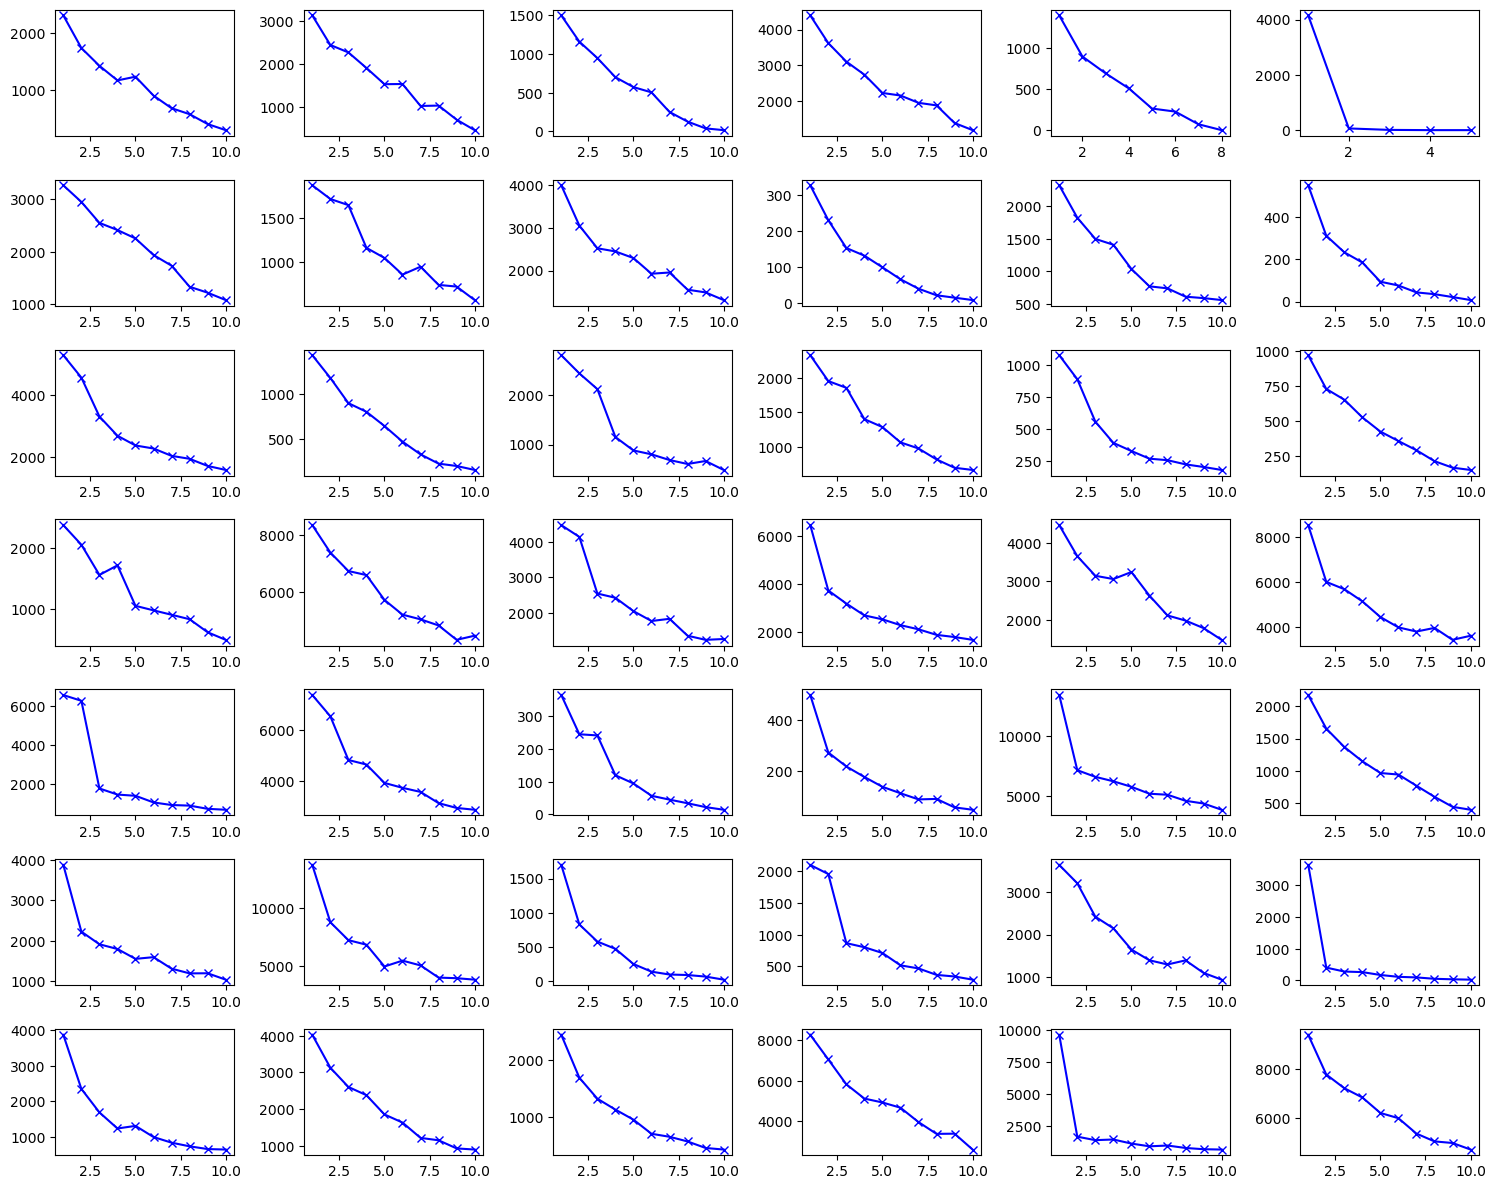

In [17]:
features_names = ['f' + str(i) for i in range(165)]
smaller_num_instances = min([x.shape[0] for x in all_timesteps])

# Set up the figure
fig, axs = plt.subplots(7, 6, figsize=(15, 12))

# Flatten the axis array for easy iteration
axs = axs.ravel()

global_wcss = []

for i, timestep in enumerate(all_timesteps[:-7]):
    data = timestep[features_names]

    from sklearn.cluster import KMeans
    import matplotlib.pyplot as plt

    # Assuming you have your data stored in X

    # Create empty list to store the within-cluster sum of squares
    wcss = []

    # Define the range of K values
    k_values = range(1, min(data.shape[0]+1, 11))

    # Calculate the within-cluster sum of squares for different values of K
    for k in k_values:
        kmeans = KMeans(n_clusters=k, n_init='auto')
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    
    global_wcss.append(wcss)

    # Plot the Elbow curve
    axs[i].plot(k_values, wcss, 'bx-')
    # axs[i].xlabel('Number of Clusters (K)')
    # axs[i].ylabel('Within-Cluster Sum of Squares')
    # axs[i].title('Elbow Method for Optimal K')
    # axs[i].axis('off')

# Hide any remaining empty subplots
for j in range(len(all_timesteps), len(axs)):
    axs[j].set_visible(False)

plt.tight_layout()
plt.savefig('elbow_method.png')
plt.show()

## Store the index of the change in cluster with highest WCSS slope

In [16]:
clusters = []

for timestep in global_wcss:
    n_clusters = None
    step = 0
    for i, value in enumerate(timestep):
        if i > 0:
            tmp = timestep[i-1] - timestep[i]
            if tmp > step:
                step = tmp
                n_clusters = i + 1
    
    clusters.append(n_clusters)

print(f'There are {len(clusters)} optimal clusters in total.')
print(clusters)

print(f'The mean value of the optimal cluster has a value of {sum(clusters)//len(clusters)}.')

There are 42 optimal clusters in total.
[4, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 3, 4, 2, 2, 5, 3, 4, 2, 2, 3, 6, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 5, 3, 2, 3]
The mean value of the optimal cluster has a value of 2.


## Compute the ratio of each class of the illicit nodes for each timestep.

In [50]:
ratios = []
for i, timestep in enumerate(all_timesteps[:-7]):
    data = timestep[features_names]
    kmeans = KMeans(n_clusters=2, n_init='auto')
    kmeans.fit(data)

    labels = kmeans.predict(data)

    class1 = [pred for pred in labels if pred == 0]
    class2 = [pred for pred in labels if pred == 1]


    ratios.append(len(class2)/len(class1))
    print(len(class2)/len(class1))

print(f'The ratio for these classes are {round(sum(ratios)/len(ratios), 3)}')

0.5454545454545454
17.0
4.5
0.5789473684210527
3.0
0.6666666666666666
0.030303030303030304
0.015151515151515152
21.545454545454547
3.5
42.666666666666664
0.06666666666666667
0.017482517482517484
6.166666666666667
3.59375
0.5058823529411764
0.43478260869565216
0.0196078431372549
0.3114754098360656
5.046511627906977
0.02040816326530612
5.869565217391305
16.666666666666668
1.3620689655172413
0.017241379310344827
18.2
5.0
2.6956521739130435
1.2689655172413794
0.0375
1.3555555555555556
0.07210031347962383
0.045454545454545456
0.05714285714285714
0.6545454545454545
0.06451612903225806
0.1111111111111111
0.18085106382978725
0.15714285714285714
0.01818181818181818
6.25
0.7969924812030075
The ratio for these classes are 4.074
